In [3]:
import os
RMG_PY_PATH = os.path.expanduser('~/Code/RMG-Py/')
RMG_MODELS_PATH = os.path.expanduser('~/Code/RMG-models/')

In [4]:
import IPython
from IPython.display import display
import sys
import os
import re

sys.path.insert(1,RMG_PY_PATH) # a copy of RMG-Py on the `importer` branch.
from rmgpy.molecule import Molecule
import rmgpy.kinetics
import numpy
import cPickle as pickle
from collections import Counter, defaultdict
from rmgpy.reaction import Reaction
import pandas as pd

In [5]:
master = 'CombFlame2012/2028-Sarathy' # this should be what was used for '--names=' when generating the .pkl files

In [6]:
# Find and read the chemkin file
with open(os.path.join(RMG_MODELS_PATH, master,'import.sh')) as infile:
    shellscript = infile.read()
reactions_filename = re.search('--reactions\s+(\S+)',shellscript).group(1)
reactions_filepath = os.path.join(RMG_MODELS_PATH,master,reactions_filename)
thermo_filename = re.search('--thermo\s+(\S+)',shellscript).group(1)
thermo_filepath = os.path.join(RMG_MODELS_PATH,master,thermo_filename)
print(reactions_filepath)
print(thermo_filepath)
with open(reactions_filepath) as infile:
    chemkin = infile.readlines()
#for i,line in enumerate(chemkin):
    #print i, line.strip()             # uncomment to print the chemkin model
    
print "".join(chemkin[:4]) # print first 4 lines only

/Users/nathan/Code/RMG-models/CombFlame2012/2028-Sarathy/model.txt
/Users/nathan/Code/RMG-models/CombFlame2012/2028-Sarathy/thermo.txt
!A comprehensive chemical kinetic combustion model for the four butanol isomers
!S.M. Sarathy, S. Vranckx, K. Yasunaga, M. Mehl, P. O�wald, W.K. Metcalfe,
!C. K. Westbrook, W.J. Pitz, K. Kohse-Hoinghaus, R.X. Fernandes, H.J Curran
!  Accepted Combustion and Flame, Dec 2011



In [7]:
# If you have an up to date cantera, then
#from cantera import ck2cti
# otherwise, do the next two cells
# no, use the hacked version of ck2cti.py in this repo

#%%bash
#curl https://raw.githubusercontent.com/Cantera/cantera/master/interfaces/cython/cantera/ck2cti.py > ck2cti.py

import ck2cti # use the hacked version of ck2cti.py in this repo

In [8]:
parser = ck2cti.Parser()
surfaces = parser.convertMech(inputFile=reactions_filepath,
                              thermoFile=thermo_filepath,
                              transportFile=None,
                              surfaceFile=None,
                              phaseName=None,
                              outName='master.cti',
                              permissive=True)
parser.reactions[0]

oh*<=>oh+hv                                  1.450e+06      0.0           0.0
If the "--permissive" option was specified, this will be converted to an irreversible reaction with the photon removed.
ch*<=>ch+hv 1.860e+06 0.0 0.0
If the "--permissive" option was specified, this will be converted to an irreversible reaction with the photon removed.
INFO:root:Skipping unexpected species "hoco" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "ch3cho2h" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "ch3coch2o2h" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "ch3coch2o" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "ch3chcho" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "c3h2" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "c5h11-1" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "c5h11-2" while reading 

Wrote CTI mechanism file to 'master.cti'.
Mechanism contains 431 species and 2346 reactions.


In [9]:
import rmgpy.rmg
import rmgpy.data
import rmgpy.data.kinetics

In [10]:
dict_path = os.path.join(RMG_MODELS_PATH, master, 'RMG-Py-kinetics-library', 'dictionary.txt')
print "Loading species_dict from",dict_path
species_dict = rmgpy.data.kinetics.KineticsLibrary().getSpecies(dict_path)

Loading species_dict from /Users/nathan/Code/RMG-models/CombFlame2012/2028-Sarathy/RMG-Py-kinetics-library/dictionary.txt


In [11]:
smiles_to_nickname_dict = {}
for species in species_dict.itervalues():
    #print len(species.molecule[0].toSMILES())
    for mol in species.molecule:
        smiles_to_nickname_dict[mol.toSMILES()] = species.label
    
smiles_to_nickname_dict
    

{'C': 'ch4',
 'C#C': 'c2h2',
 'C#CC': 'c3h4-p',
 'C#CC#C': 'c4h2',
 'C#CC=C': 'c4h4',
 'C#CO': 'hccoh',
 'C#C[CH2]': 'c3h3',
 'C#C[C]=C': 'c4h3-i',
 'C#C[O]': 'hcco',
 'C1=CC1': 'cc3h4',
 'C1=CCOC1': 'c4h6o25',
 'C1=COCC1': 'c4h6o23',
 'C1C=COC=1': 'c4h4o',
 'C1CCOC1': 'c4h8o1-4',
 'C1CO1': 'c2h4o1-2',
 'C1COC1': 'c3h6o1-3',
 'C=C': 'c2h4',
 'C=C(C)C': 'ic4h8',
 'C=C(C)C=O': 'ic3h5cho',
 'C=C(C)CO': 'ic4h7oh',
 'C=C(C)COO': 'ic4h7ooh',
 'C=C(C)C[O]': 'ic4h7o',
 'C=C(C)O': 'ic3h5oh',
 'C=C(C)[C]=O': 'ic3h5co',
 'C=C(C)[O]': 'ch3coch2',
 'C=C(O)CC': 'c4h7oh1-2',
 'C=C(O)[CH]C': 'c4h6oh1-32',
 'C=C([O])CC': 'c2h5coch2',
 'C=C=C': 'c3h4-a',
 'C=C=C=C=O': 'h2c4o',
 'C=C=CC': 'c4h612',
 'C=C=O': 'ch2co',
 'C=C=[C]C': 'c4h5-2',
 'C=CC': 'c3h6',
 'C=CC(C)=O': 'c2h3coch3',
 'C=CC(C)O': 'c4h7oh1-3',
 'C=CC(C)[O]': 'c4h7o',
 'C=CC=C': 'c4h6',
 'C=CC=CO': 'c4h5oh-13',
 'C=CC=C[O]': 'ch2chchcho',
 'C=CC=O': 'c2h3cho',
 'C=CCC': 'c4h8-1',
 'C=CCCO': 'c4h7oh1-4',
 'C=CCO': 'c3h5oh',
 'C=CCOO': 'ac3h5

In [12]:
f = open("/Users/nathan/Code/autotst_kinetics.pkl","r")
autotst_kinetics = pickle.load(f)
ooh_reactions = []
for rxn in autotst_kinetics:
    reactants, products = rxn.label.split("_")
    r1, r2 = reactants.split('+')
    p1, p2 = products.split('+')
    if "OO" in [r1, r2, p1, p2] and "[O]O" in [r1, r2, p1, p2]:
        #print [r1, r2, p1, p2]
        ooh_reactions.append(rxn)
        
len(ooh_reactions)

571

In [13]:
sarathy_rxns = []
for r in parser.reactions:
    split_string = str(r).split()
    if not ('ho2' in split_string and 'h2o2' in split_string):
        continue
    reactants = [species_dict[n].molecule[0].toSMILES() for n in r.reactantString.split(' + ')]
    products = [species_dict[n].molecule[0].toSMILES() for n in r.productString.split(' + ')]
    import itertools
    joined_reactant_orders = ['+'.join(order) for order in itertools.permutations(reactants)]
    joined_product_orders = ['+'.join(order) for order in itertools.permutations(products)]
    possible_labels = ['_'.join((joined_r, joined_p)) for joined_r in joined_reactant_orders for joined_p in joined_product_orders]
    
    
    for reaction in ooh_reactions:
        ooh_reactants, ooh_products = reaction.label.split("_")
        r1, r2 = ooh_reactants.split("+")
        p1, p2 = ooh_products.split("+")
        ooh_smiles = [r1, r2, p1, p2]
        
        inchikey_to_smiles_dict = {}
        for smiles in ooh_smiles:
            inchikey_to_smiles_dict[Molecule(SMILES=smiles).toInChIKey()] = smiles
        
    
        
        if reaction.label in possible_labels:
            for reactant in reaction.reactants:
                inchi_key = reactant.label.split("-u")[0]
                if not reactant.label in smiles_to_nickname_dict.itervalues():
                    reactant.molecule = [Molecule(SMILES=inchikey_to_smiles_dict[inchi_key])]
                    reactant.label = smiles_to_nickname_dict[inchikey_to_smiles_dict[inchi_key]]
                
                
            for product in reaction.products:
                inchi_key = product.label.split("-u")[0]
                if not product.label in smiles_to_nickname_dict.itervalues():
                    product.molecule = [Molecule(SMILES=inchikey_to_smiles_dict[inchi_key])]
                    product.label = smiles_to_nickname_dict[inchikey_to_smiles_dict[inchi_key]]
                
                
            
            sarathy_rxns.append([r, reaction, reaction.toChemkin(), reaction.toCantera()])
        
df = pd.DataFrame(sarathy_rxns)

df.columns = ["Sarathy Reaction", "AutoTST Reaction", "AutoTST Reaction - Chemkin" , "AutoTST - Cantera"]

df

,Sarathy Reaction,AutoTST Reaction,AutoTST Reaction - Chemkin,AutoTST - Cantera
0,h2o2 + h <=> h2 + ho2,h2o2 + h <=> h2 + ho2,"! Fitted to 59 data points; dA = *|/ 1.57377, ...",h + h2o2 <=> h2 + ho2
1,ch2o + ho2 <=> hco + h2o2,ch2o + ho2 <=> h2o2 + hco,"! Fitted to 59 data points; dA = *|/ 2.04573, ...",ch2o + ho2 <=> h2o2 + hco
2,ch3oh + ho2 <=> ch2oh + h2o2,ho2 + ch3oh <=> ch2oh + h2o2,"! Fitted to 59 data points; dA = *|/ 1.49501, ...",ch3oh + ho2 <=> ch2oh + h2o2
3,c2h6 + ho2 <=> c2h5 + h2o2,c2h6 + ho2 <=> c2h5 + h2o2,"! Fitted to 59 data points; dA = *|/ 1.37627, ...",c2h6 + ho2 <=> c2h5 + h2o2
4,c2h4o1-2 + ho2 <=> c2h3o1-2 + h2o2,c2h4o1-2 + ho2 <=> h2o2 + c2h3o1-2,"! Fitted to 59 data points; dA = *|/ 1.07588, ...",c2h4o1-2 + ho2 <=> c2h3o1-2 + h2o2
5,ch3cho + ho2 <=> ch3co + h2o2,ch3cho + ho2 <=> h2o2 + ch3co,"! Fitted to 59 data points; dA = *|/ 1.59886, ...",ch3cho + ho2 <=> ch3co + h2o2
6,h2o2 + ch3co3 <=> ho2 + ch3co3h,ch3co3 + h2o2 <=> ho2 + ch3co3h,"! Fitted to 59 data points; dA = *|/ 1.11476, ...",ch3co3 + h2o2 <=> ch3co3h + ho2
7,c2h5oh + ho2 <=> sc2h4oh + h2o2,ho2 + c2h5oh <=> sc2h4oh + h2o2,"! Fitted to 59 data points; dA = *|/ 1.28209, ...",c2h5oh + ho2 <=> h2o2 + sc2h4oh
8,c2h5oh + ho2 <=> pc2h4oh + h2o2,c2h5oh + ho2 <=> pc2h4oh + h2o2,"! Fitted to 59 data points; dA = *|/ 1.17747, ...",c2h5oh + ho2 <=> h2o2 + pc2h4oh
9,c2h3cho + ho2 <=> c2h3co + h2o2,c2h3cho + ho2 <=> c2h3co + h2o2,"! Fitted to 59 data points; dA = *|/ 1.91111, ...",c2h3cho + ho2 <=> c2h3co + h2o2


In [14]:
print type(df.iloc[:,0])

<class 'pandas.core.series.Series'>


In [15]:

chemkin_string = df.iloc[0,2]
chemkin_string = '\n'.join([l for l in chemkin_string.splitlines() if not l.startswith('!')])
chemkin_string
cantera_reaction, reverse_reaction = parser.readKineticsEntry(chemkin_string, False)
cti_string = str(cantera_reaction)
cantera_reaction.to_cti()

"reaction('h2o2 + h <=> h2 + ho2', [1.651000e+02, 3.267, 1.0])"

In [16]:
parser.energy_units = 'kcal/mol'
reactions_by_cti_string = {}
for entry in zip(df.iloc[:,1], df.iloc[:,2]):
    reaction, chemkin_string = entry
    kinetics = reaction.kinetics
    chemkin_string = '\n'.join([l for l in chemkin_string.splitlines() if not l.startswith('!')])
    chemkin_string
    cantera_reaction, reverse_reaction = parser.readKineticsEntry(chemkin_string, False)
    cti_string = str(cantera_reaction)
    reactions_by_cti_string[cti_string] = (reaction, chemkin_string, cantera_reaction)
    
print len(reactions_by_cti_string)
print '\n'.join(sorted(reactions_by_cti_string.keys()))

55
c2h3cho + ho2 <=> c2h3co + h2o2
c2h4o1-2 + ho2 <=> h2o2 + c2h3o1-2
c2h5cho + ho2 <=> c2h5co + h2o2
c2h5coch3 + ho2 <=> c2h5coch2 + h2o2
c2h5oh + ho2 <=> pc2h4oh + h2o2
c2h6 + ho2 <=> c2h5 + h2o2
c3h6 + ho2 <=> h2o2 + c3h5-a
c3h8 + ho2 <=> h2o2 + ic3h7
c3h8 + ho2 <=> h2o2 + nc3h7
c4h10 + ho2 <=> pc4h9 + h2o2
c4h8oh-4o2 + h2o2 <=> c4h8oh-4o2h + ho2
ch2o + ho2 <=> h2o2 + hco
ch3cho + ho2 <=> h2o2 + ch3co
ch3co3 + h2o2 <=> ho2 + ch3co3h
ch3och3 + ho2 <=> h2o2 + ch3och2
ch3ocho + ho2 <=> h2o2 + ch3oco
h2o2 + c4h8oh-2o2 <=> ho2 + c4h8oh-2o2h
h2o2 + h <=> h2 + ho2
h2o2 + ic4h8oh-1o2 <=> ho2 + ic4h8oh-1o2h
h2o2 + ic4h8oh-2o2 <=> ho2 + ic4h8oh-2o2h
h2o2 + sc4h8oh-3o2 <=> ho2 + sc4h8oh-3o2h
h2o2 + sc4h8oh-mo2 <=> sc4h8oh-mo2h + ho2
h2o2 + sc4h9o2 <=> sc4h9o2h + ho2
ho2 + c2h5coch3 <=> ch2ch2coch3 + h2o2
ho2 + c2h5oh <=> sc2h4oh + h2o2
ho2 + c4h10 <=> sc4h9 + h2o2
ho2 + c4h7oh1-2 <=> h2o2 + c4h6oh1-32
ho2 + c4h8-1 <=> h2o2 + c4h71-4
ho2 + ch3ocho <=> ch2ocho + h2o2
ho2 + ch3oh <=> ch2oh + h2o2

In [17]:
import textwrap
original_reactions = list()
alternatives_rates = defaultdict(list)
for i, r in enumerate(parser.reactions):
    original_reactions.append(r)
    assert original_reactions[i] == parser.reactions[i]
    
    if r in list(df.iloc[:,0]):
        #print df[r == df.iloc[:,0]]
        #print r
        #print reactions_by_cti_string[str(r)]
        _, rmg_reaction, kinetics_options, ct_version_of_rmg_kinetics = df[r == df.iloc[:,0]].values[0]
        # we just want the rmg_reaction
        
        #rmg_reaction.kinetics = k
        chemkin_string = rmg_reaction.toChemkin()
        chemkin_string = '\n'.join([l for l in chemkin_string.splitlines() if not l.startswith('!')])
        r2, reverse_reaction = parser.readKineticsEntry(chemkin_string, False)
        # r2 is the new replacement reaction

        """assert r2.reactants == r.reactants
        assert r2.products == r.products
        assert r2.reversible == r.reversible
        assert r2.duplicate == r.duplicate
        assert r2.fwdOrders == r.fwdOrders
        """
        r2.comment = r.comment
        r2.comment += '\n \nSUBSTITUTION: The following reaction was originally\n{}\n'.format(r.to_cti())
        #model_list = textwrap.fill(', '.join(models), break_on_hyphens=False, break_long_words=False)
        r2.comment += 'But has been replaced with the following as seen in AutoTST'

        alternatives_rates[i].append(r2)

        print
        print '\n'.join(['# '+c for c in r2.comment.split('\n') if c])
        print r2.to_cti()




# ref: ellingson j. phys. chem. (2007) 111, (51), 13554-13566
#  
# SUBSTITUTION: The following reaction was originally
# reaction('h2o2 + h <=> h2 + ho2', [2.150000e+10, 1.0, 6000.0])
# But has been replaced with the following as seen in AutoTST
reaction('h2o2 + h <=> h2 + ho2', [1.651000e+02, 3.267, (1.016, 'kcal/mol')])

# wkm 01/11/10
# !ref:Fit to Hidaka et al. and Jemi-Alade,A.A.
# ch2o+ho2<=>hco+h2o2 7.100e-03 4.517 6.580e+03
# ref:J. Phys. Chem. A 109, 12027-12035, 2005
#  
# SUBSTITUTION: The following reaction was originally
# reaction('ch2o + ho2 <=> hco + h2o2', [1.880000e+04, 2.7, 11520.0])
# But has been replaced with the following as seen in AutoTST
reaction('ch2o + ho2 <=> h2o2 + hco', [4.257000e-06, 5.203, (5.098, 'kcal/mol')])

# ref:curran estimate
#  
# SUBSTITUTION: The following reaction was originally
# reaction('ch3oh + ho2 <=> ch2oh + h2o2', [1.080000e+04, 2.55, 10530.0])
# But has been replaced with the following as seen in AutoTST
reaction('ho2 + ch3oh <=> c

In [18]:
print "original reactions", len(parser.reactions)
print "reactions to change", len(alternatives_rates)
c = Counter(map(len,alternatives_rates.values()))
print "substitutions", sorted(c.items())
print "total variations", sum(map(len,alternatives_rates.values()))

original reactions 2346
reactions to change 55
substitutions [(1, 55)]
total variations 55


In [19]:
# this creates ~1281 cantera files, each with a single variation
outdir = 'Cantera_models_rates'
os.path.exists(outdir) or os.mkdir(outdir)
for f in os.listdir(outdir):
    os.unlink(os.path.join(outdir, f))

In [20]:
parser.writeCTI(outName=os.path.join(outdir,'master.0.0.cti'))
for i, options in alternatives_rates.iteritems():
    for j, replacement in enumerate(options):
        output_filename = 'master.{}.{}.cti'.format(i+1,j+1)
        parser.reactions[i] = replacement
        ## save the file!
        header = ["####################################################",
                  "##  Reaction {:2d} has been replaced with option {:2d}  ##".format(i+1,j+1),
                  "####################################################"]
        print "saving", output_filename
        parser.writeCTI(header=header, outName=os.path.join(outdir,output_filename))
        # restore original
        parser.reactions[i] = original_reactions[i]

saving master.2177.1.cti
saving master.263.1.cti
saving master.1645.1.cti
saving master.787.1.cti
saving master.788.1.cti
saving master.22.1.cti
saving master.410.1.cti
saving master.1564.1.cti
saving master.1565.1.cti
saving master.1566.1.cti
saving master.1567.1.cti
saving master.1568.1.cti
saving master.1953.1.cti
saving master.1187.1.cti
saving master.421.1.cti
saving master.2247.1.cti
saving master.552.1.cti
saving master.1194.1.cti
saving master.1195.1.cti
saving master.1196.1.cti
saving master.1325.1.cti
saving master.1326.1.cti
saving master.435.1.cti
saving master.1081.1.cti
saving master.2106.1.cti
saving master.1211.1.cti
saving master.1473.1.cti
saving master.196.1.cti
saving master.2245.1.cti
saving master.2246.1.cti
saving master.839.1.cti
saving master.2248.1.cti
saving master.1482.1.cti
saving master.77.1.cti
saving master.1955.1.cti
saving master.1233.1.cti
saving master.2105.1.cti
saving master.473.1.cti
saving master.474.1.cti
saving master.1758.1.cti
saving master.2

In [26]:
import os, sys
from collections import defaultdict
import cantera as ct
import numpy as np
import pandas as pd
import itertools
import random
import matplotlib.pyplot as plt

def get_ignition_delay(cantera_file_path, temperature , pressure, stoichiometry=1.0, plot=False, isomer='n'):
    """
    Get the ignition delay at temperature (K) and pressure (bar) and stochiometry (phi),
    for the butanol isomer (n,s,t,i)
    """
    try:
        ct.suppress_thermo_warnings(True)
    except AttributeError:
        print("Sorry about the warnings...")
    gas = ct.Solution(cantera_file_path)
    assert isomer in ['n','s','t','i'], "Expecting isomer n,s,t, or i not {}".format(isomer)
    oxygen_mole = 1.0
    argon_mole = 96./4.*oxygen_mole
    butanol_mole = stoichiometry * oxygen_mole/6.
    X_string = isomer + 'c4h9oh:{0}, o2:{1}, ar:{2}'.format(butanol_mole, oxygen_mole, argon_mole)
    gas.TPX = temperature, pressure*1e5, X_string
    reactor=ct.IdealGasReactor(gas)
    reactor_network=ct.ReactorNet([reactor])
    time=0.0
    end_time=1000e-3
    times=[]
    concentrations=[]
    
    pressures=[]
    temperatures=[]
    print_data = True
    while time < end_time:
        time=reactor_network.time
        times.append(time)
        temperatures.append(reactor.T)
        pressures.append(reactor.thermo.P)
        concentrations.append(reactor.thermo.concentrations)
        reactor_network.step(end_time)
    print("reached end time {0:.4f} ms in {1} steps ". format(times[-1]*1e3, len(times)))
    concentrations = np.array(concentrations)
    times = np.array(times)
    pressures = np.array(pressures)
    temperatures = np.array(temperatures)
    
    dTdt = (temperatures[1:] - temperatures[:-1]) / (times[1:] - times[:-1])
    
    if plot:
        plt.subplot(2,1,1)
        plt.plot(times,temperatures)
        plt.subplot(2,1,2)
        plt.plot(times[1:], dTdt)
        plt.show()
        
    step_with_fastest_T_rise = dTdt.argmax()
    if step_with_fastest_T_rise > 1 and step_with_fastest_T_rise < len(times)-2:
        ignition_time_ms = 1e3 * times[step_with_fastest_T_rise]
        print("At {0} K {1} bar, ignition delay time is {2} ms for {3}-butanol".format(temperature,pressure,ignition_time_ms,isomer))
        return ignition_time_ms
    else:
        print("At {0} K {1} bar, no ignition is detected for {2}-butanol" .format(temperature, pressure, isomer))
        return np.infty

Sorry about the warnings...


**** WARNING ****
For species oh*, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.6206
	Value computed using high-temperature polynomial: 53.5842


**** WARNING ****
For species ch3o2, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  11.5313
	Value computed using high-temperature polynomial: 11.5482


**** WARNING ****
For species ch*, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  107.505
	Value computed using high-temperature polynomial: 107.348


**** WARNING ****
For species c2h2oh, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  12.2546
	Value computed using high-temperature polynomial: 12.2718


**** WARNING ****
For species ch2co, discontinuity in cp/R detected at Tmid = 1000
	Value computed using low-temperature polynomial:  10.0876
	Value computed usi

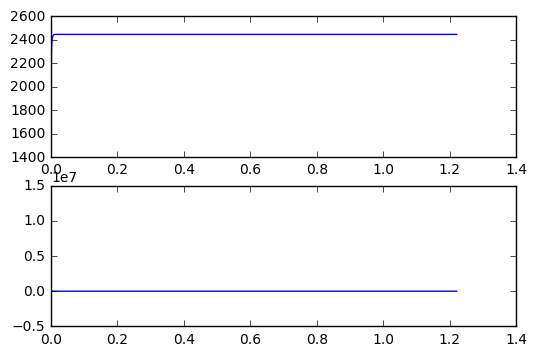

At 1500 K 1 bar, ignition delay time is 0.20939997632 ms for n-butanol


0.20939997632006779

In [34]:
get_ignition_delay("/Users/nathan/Code/OOHabstraction/comparisonTST/ipython_notebooks/Cantera_models_rates/master.1194.1.cti", 
                   temperature=1500 , 
                   pressure=1, 
                   stoichiometry=1.0, 
                   plot=True)